## 📚 PENJELASAN KONFIGURASI - RESNET18 + CBAM

### ⚠️ CATATAN PENTING
**ResNet18 TIDAK tersedia di `tensorflow.keras.applications`!**

Notebook ini menggunakan **Custom ResNet18 + CBAM (Convolutional Block Attention Module)** yang dibangun manual.

### 🧠 Apa Itu CBAM?
CBAM adalah **attention mechanism** yang membantu model "fokus" pada fitur yang paling penting.
CBAM terdiri dari 2 komponen:

1. **Channel Attention** → Menentukan **"APA"** yang penting (channel/filter mana yang relevan)
   - Menggunakan Global Average Pooling + Global Max Pooling
   - Shared MLP untuk menghasilkan bobot per channel
   
2. **Spatial Attention** → Menentukan **"DI MANA"** yang penting (lokasi mana di gambar)
   - Menggunakan Average + Max pooling across channels
   - Conv 7×7 untuk menghasilkan attention map spasial

### 📊 Referensi
- **Woo et al. (2018)** "CBAM: Convolutional Block Attention Module" - ECCV 2018
- ResNet50 + CBAM: Top-1 Error 22.66% vs 24.56% baseline (ImageNet)

### 🌽 Mengapa CBAM untuk Aflatoxin?
- **Spatial attention** membantu fokus pada area kernel jagung yang berfluoresensi
- **Channel attention** memilih spektral/warna yang relevan untuk deteksi aflatoxin

### ⚙️ Parameter Baru
| Parameter | Default | Penjelasan |
|-----------|---------|------------|
| `USE_CBAM` | True | Aktifkan/nonaktifkan CBAM |
| `SE_REDUCTION_RATIO` | 16 | Rasio reduksi bottleneck di channel attention |
| `SPATIAL_KERNEL_SIZE` | 7 | Ukuran kernel untuk spatial attention (7 optimal) |

### 📐 Perbedaan dengan ModelResNet18.ipynb (Tanpa CBAM)
| Aspek | Tanpa CBAM | Dengan CBAM |
|-------|------------|-------------|
| Basic Block | Conv→BN→ReLU→Conv→BN→Add | Conv→BN→ReLU→Conv→BN→**CBAM**→Add |
| Parameter | ~11.2M | ~11.3M (+0.1M dari CBAM) |
| Fokus Model | Semua fitur sama rata | Fitur penting diberi bobot lebih |
| Interpretability | Grad-CAM saja | Grad-CAM + Attention Map |


In [18]:
# =================================================================================================
# 1. SETUP & LOAD DATA (MENGGUNAKAN PREPROCESS YANG SUDAH ADA)
# =================================================================================================

# Memanggil file preprocess_resnet18.ipynb agar variabel train_ds, val_ds, test_ds tersedia
# Pastikan file preprocess_resnet18.ipynb berada di folder yang sama
%run preprocess_resnet18.ipynb

import os
import tensorflow as tf
from tensorflow.keras.layers import (
    Dense, GlobalAveragePooling2D, GlobalMaxPooling2D, Dropout, Input,
    Conv2D, BatchNormalization, Activation, MaxPooling2D, Add,
    Reshape, Multiply, Concatenate, Lambda
)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import AdamW, SGD, RMSprop, Adam
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pandas as pd
import numpy as np
from datetime import datetime

class FocalLoss(tf.keras.losses.Loss):
    def __init__(self, alpha=1.0, gamma=2.0, name='focal_loss'):
        super().__init__(name=name)
        self.alpha = tf.constant(alpha, dtype=tf.float32)
        self.gamma = gamma
    
    def call(self, y_true, y_pred):
        # # Clip predictions
        # epsilon = tf.keras.backend.epsilon()
        # y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
        
        # # Calculate cross entropy
        # ce = -y_true * tf.math.log(y_pred)
        
        # # Calculate focal weight
        # pt = y_true * y_pred
        # pt = tf.reduce_sum(pt, axis=-1, keepdims=True)
        # focal_weight = tf.pow(1.0 - pt, self.gamma)
        
        # # Apply focal loss
        # focal_loss = self.alpha * focal_weight * tf.reduce_sum(ce, axis=-1, keepdims=True)
        # 1. Konversi sparse label ke one-hot secara otomatis
        # asumsikan ada 4 kelas
        y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=4)
        y_true = tf.reshape(y_true, [-1, 4]) # Pastikan shape sesuai

        # 2. Clip predictions untuk menghindari log(0)
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
        
        # 3. Hitung Cross Entropy
        ce = -y_true * tf.math.log(y_pred)
        
        # 4. Hitung Focal Weight (fokus pada sampel sulit)
        pt = tf.reduce_sum(y_true * y_pred, axis=-1)
        focal_weight = tf.pow(1.0 - pt, self.gamma)
        
        # 5. Terapkan Alpha (sebagai pengganti class_weights)
        # Jika alpha adalah list, dia akan mengambil bobot kelas yang sesuai
        alpha_factor = tf.reduce_sum(self.alpha * y_true, axis=-1)
        
        # 6. Hitung hasil akhir
        focal_loss = alpha_factor * focal_weight * tf.reduce_sum(ce, axis=-1)
        return tf.reduce_mean(focal_loss)


TensorFlow version: 2.20.0
TensorFlow Hub version: 0.16.1
GPU Available: []
Konfigurasi:
  - Image Size: 224x224
  - Batch Size: 32
  - Num Classes: 4
  - Data Path: dataset_final
PROSES PEMUATAN DATASET

[1/3] Memuat dataset_final\train
Found 865 files belonging to 4 classes.



[2/3] Memuat dataset_final\val
Found 134 files belonging to 4 classes.

[3/3] Memuat dataset_final\test
Found 135 files belonging to 4 classes.

INFORMASI KELAS & MAPPING
Kelas ditemukan: ['1', '2', '3', '4']

Index      | Folder     | Kandungan Aflatoksin
--------------------------------------------------
0          | 1          | 1 PPB
1          | 2          | 2 PPB
2          | 3          | 3 PPB
3          | 4          | 4 PPB
Setting up data augmentation...
✓ RandomFlip (horizontal)
✓ RandomRotation (±1.6°)

❌ RandomBrightness - TIDAK DIGUNAKAN (mengubah nilai PPB)
❌ RandomContrast - TIDAK DIGUNAKAN (mengubah nilai PPB)
Fungsi preprocessing untuk ResNet18 telah dibuat.

Normalisasi yang digunakan:
  - Input: [0, 255]
  - Output: [0, 1]
Menerapkan preprocessing ke dataset...
✓ Training dataset: augmentation ON, cache ON, prefetch ON
✓ Validation dataset: augmentation OFF, cache ON, prefetch ON
✓ Test dataset: augmentation OFF, cache ON, prefetch ON

PREPROCESSING SELESAI

Dataset

In [19]:
# =================================================================================================
# 1.5 CBAM MODULE + CUSTOM RESNET18 BUILDER
# =================================================================================================
# CBAM = Convolutional Block Attention Module (Woo et al., ECCV 2018)
# Terdiri dari: Channel Attention → Spatial Attention (sequential)

# ─────────────────────────────────────────────────────────────────────
# CBAM COMPONENTS
# ─────────────────────────────────────────────────────────────────────

def channel_attention(input_tensor, reduction_ratio=16, name='ca'):
    """
    Channel Attention Module
    
    Menentukan "APA" yang penting → bobot per channel
    
    Flow: Input → [AvgPool + MaxPool] → SharedMLP → Sigmoid → Scale
    
    Args:
        input_tensor: Feature map [batch, H, W, C]
        reduction_ratio: Bottleneck ratio (default: 16)
    Returns:
        Recalibrated feature map [batch, H, W, C]
    """
    channels = input_tensor.shape[-1]
    
    # Shared MLP layers (digunakan untuk avg dan max path)
    shared_dense1 = Dense(channels // reduction_ratio, activation='relu', name=f'{name}_fc1')
    shared_dense2 = Dense(channels, activation=None, name=f'{name}_fc2')
    
    # === Average Pooling Path ===
    avg_pool = GlobalAveragePooling2D(name=f'{name}_avgpool')(input_tensor)
    avg_out = shared_dense1(avg_pool)
    avg_out = shared_dense2(avg_out)
    
    # === Max Pooling Path ===
    max_pool = GlobalMaxPooling2D(name=f'{name}_maxpool')(input_tensor)
    max_out = shared_dense1(max_pool)
    max_out = shared_dense2(max_out)
    
    # === Combine + Sigmoid ===
    attention = Add(name=f'{name}_add')([avg_out, max_out])
    attention = Activation('sigmoid', name=f'{name}_sigmoid')(attention)
    attention = Reshape((1, 1, channels), name=f'{name}_reshape')(attention)
    
    # === Scale (element-wise multiply) ===
    output = Multiply(name=f'{name}_scale')([input_tensor, attention])
    
    return output


def spatial_attention(input_tensor, kernel_size=7, name='sa'):
    """
    Spatial Attention Module
    
    Menentukan "DI MANA" yang penting → bobot per lokasi pixel
    
    Flow: Input → [AvgPool + MaxPool across C] → Concat → Conv7x7 → Sigmoid → Scale
    
    Args:
        input_tensor: Feature map [batch, H, W, C]
        kernel_size: Convolution kernel size (default: 7)
    Returns:
        Recalibrated feature map [batch, H, W, C]
    """
    # Average pooling across channel axis → [batch, H, W, 1]
    avg_pool = Lambda(
        lambda x: tf.reduce_mean(x, axis=-1, keepdims=True),
        name=f'{name}_avgpool'
    )(input_tensor)
    
    # Max pooling across channel axis → [batch, H, W, 1]
    max_pool = Lambda(
        lambda x: tf.reduce_max(x, axis=-1, keepdims=True),
        name=f'{name}_maxpool'
    )(input_tensor)
    
    # Concatenate → [batch, H, W, 2]
    concat = Concatenate(axis=-1, name=f'{name}_concat')([avg_pool, max_pool])
    
    # Convolution → [batch, H, W, 1]
    attention = Conv2D(
        1, kernel_size, padding='same', 
        activation='sigmoid', use_bias=False,
        name=f'{name}_conv'
    )(concat)
    
    # Scale (element-wise multiply)
    output = Multiply(name=f'{name}_scale')([input_tensor, attention])
    
    return output


def cbam_block(input_tensor, reduction_ratio=16, kernel_size=7, name='cbam'):
    """
    CBAM: Sequential Channel → Spatial Attention
    
    Paper: Woo et al. "CBAM" ECCV 2018
    Sequential order (Channel → Spatial) terbukti lebih baik dari parallel.
    
    Args:
        input_tensor: Feature map [batch, H, W, C]
        reduction_ratio: Channel attention bottleneck ratio
        kernel_size: Spatial attention conv kernel size
    Returns:
        Refined feature map [batch, H, W, C]
    """
    # Step 1: Channel Attention ("APA" yang penting)
    x = channel_attention(input_tensor, reduction_ratio, name=f'{name}_ch')
    
    # Step 2: Spatial Attention ("DI MANA" yang penting)
    x = spatial_attention(x, kernel_size, name=f'{name}_sp')
    
    return x


# ─────────────────────────────────────────────────────────────────────
# RESNET18 BUILDING BLOCKS (DENGAN CBAM)
# ─────────────────────────────────────────────────────────────────────

def basic_block(x, filters, stride=1, downsample=None, 
                use_cbam=True, reduction_ratio=16, spatial_kernel=7, name=None):
    """
    Basic Block untuk ResNet18/34 + Optional CBAM
    
    Struktur:
    - Tanpa CBAM: x → Conv3x3 → BN → ReLU → Conv3x3 → BN → Add(x) → ReLU
    - Dengan CBAM: x → Conv3x3 → BN → ReLU → Conv3x3 → BN → CBAM → Add(x) → ReLU
    """
    identity = x
    
    # First conv
    out = Conv2D(filters, 3, strides=stride, padding='same', 
                 use_bias=False, name=f'{name}_conv1')(x)
    out = BatchNormalization(name=f'{name}_bn1')(out)
    out = Activation('relu', name=f'{name}_relu1')(out)
    
    # Second conv
    out = Conv2D(filters, 3, strides=1, padding='same', 
                 use_bias=False, name=f'{name}_conv2')(out)
    out = BatchNormalization(name=f'{name}_bn2')(out)
    
    # ★★★ CBAM ATTENTION ★★★
    if use_cbam:
        out = cbam_block(out, reduction_ratio, spatial_kernel, name=f'{name}_cbam')
    
    # Shortcut connection
    if downsample is not None:
        identity = downsample(x)
    
    out = Add(name=f'{name}_add')([out, identity])
    out = Activation('relu', name=f'{name}_relu2')(out)
    
    return out

def make_layer(x, filters, blocks, stride=1, 
               use_cbam=True, reduction_ratio=16, spatial_kernel=7, name=None):
    """
    Membuat layer yang terdiri dari beberapa basic blocks
    """
    downsample = None
    
    # Jika stride != 1 atau jumlah filter berubah, perlu downsample
    if stride != 1 or x.shape[-1] != filters:
        downsample = Sequential([
            Conv2D(filters, 1, strides=stride, use_bias=False),
            BatchNormalization()
        ], name=f'{name}_downsample')
    
    # First block (mungkin perlu downsample)
    x = basic_block(x, filters, stride, downsample, 
                    use_cbam, reduction_ratio, spatial_kernel,
                    name=f'{name}_block1')
    
    # Remaining blocks
    for i in range(1, blocks):
        x = basic_block(x, filters, 
                       use_cbam=use_cbam, 
                       reduction_ratio=reduction_ratio,
                       spatial_kernel=spatial_kernel,
                       name=f'{name}_block{i+1}')
    
    return x

def build_resnet18_base(input_shape=(224, 224, 3), 
                        use_cbam=True, reduction_ratio=16, spatial_kernel=7):
    """
    Membangun base ResNet18 + CBAM (tanpa classification head)
    
    Struktur:
    - Conv1: 7x7, 64 filters, stride 2
    - MaxPool: 3x3, stride 2  
    - Layer1: 2 basic blocks, 64 filters  (+CBAM)
    - Layer2: 2 basic blocks, 128 filters (+CBAM)
    - Layer3: 2 basic blocks, 256 filters (+CBAM)
    - Layer4: 2 basic blocks, 512 filters (+CBAM)
    - Global Average Pooling → Output: 512-dim vector
    """
    inputs = Input(shape=input_shape, name='input')
    
    # Initial convolution (conv1)
    x = Conv2D(64, 7, strides=2, padding='same', use_bias=False, name='conv1')(inputs)
    x = BatchNormalization(name='bn1')(x)
    x = Activation('relu', name='relu1')(x)
    x = MaxPooling2D(3, strides=2, padding='same', name='maxpool')(x)
    
    # Residual layers (CBAM diterapkan di setiap basic block)
    x = make_layer(x, 64,  2, stride=1, use_cbam=use_cbam, 
                   reduction_ratio=reduction_ratio, spatial_kernel=spatial_kernel, name='layer1')
    x = make_layer(x, 128, 2, stride=2, use_cbam=use_cbam,
                   reduction_ratio=reduction_ratio, spatial_kernel=spatial_kernel, name='layer2')
    x = make_layer(x, 256, 2, stride=2, use_cbam=use_cbam,
                   reduction_ratio=reduction_ratio, spatial_kernel=spatial_kernel, name='layer3')
    x = make_layer(x, 512, 2, stride=2, use_cbam=use_cbam,
                   reduction_ratio=reduction_ratio, spatial_kernel=spatial_kernel, name='layer4')
    
    # Global average pooling
    x = GlobalAveragePooling2D(name='avgpool')(x)
    
    model = Model(inputs=inputs, outputs=x, name='resnet18_cbam_base')
    return model

# Test build dan tampilkan info
print("=" * 60)
print("CUSTOM RESNET18 + CBAM ARCHITECTURE")
print("=" * 60)
print("\nStruktur ResNet18 + CBAM:")
print("  - Conv1: 7x7, 64 filters, stride 2")
print("  - MaxPool: 3x3, stride 2")
print("  - Layer1: 2 basic blocks × 64 filters  + CBAM")
print("  - Layer2: 2 basic blocks × 128 filters + CBAM")
print("  - Layer3: 2 basic blocks × 256 filters + CBAM")
print("  - Layer4: 2 basic blocks × 512 filters + CBAM")
print("  - Global Average Pooling → 512-dim")

_test_base = build_resnet18_base(use_cbam=True)
_test_base_no_cbam = build_resnet18_base(use_cbam=False)
print(f"\n✓ With CBAM    - Layers: {len(_test_base.layers)}, Params: {_test_base.count_params():,}")
print(f"✓ Without CBAM - Layers: {len(_test_base_no_cbam.layers)}, Params: {_test_base_no_cbam.count_params():,}")
print(f"✓ CBAM overhead: +{_test_base.count_params() - _test_base_no_cbam.count_params():,} parameters")
del _test_base, _test_base_no_cbam


CUSTOM RESNET18 + CBAM ARCHITECTURE

Struktur ResNet18 + CBAM:
  - Conv1: 7x7, 64 filters, stride 2
  - MaxPool: 3x3, stride 2
  - Layer1: 2 basic blocks × 64 filters  + CBAM
  - Layer2: 2 basic blocks × 128 filters + CBAM
  - Layer3: 2 basic blocks × 256 filters + CBAM
  - Layer4: 2 basic blocks × 512 filters + CBAM
  - Global Average Pooling → 512-dim

✓ With CBAM    - Layers: 169, Params: 11,275,976
✓ Without CBAM - Layers: 65, Params: 11,186,112
✓ CBAM overhead: +89,864 parameters


In [24]:
# =================================================================================================
# 2. KONFIGURASI EKSPERIMEN (UBAH PARAMETER DI SINI SETIAP KALI RUNNING)
# =================================================================================================
# Ini adalah "Control Panel" kamu. Ubah angka di sini, lalu Run All.

# --- Parameter CBAM (BARU!) ---
USE_CBAM = True             # True = pakai CBAM, False = ResNet18 biasa
SE_REDUCTION_RATIO = 16     # Rasio bottleneck channel attention (default: 16)
SPATIAL_KERNEL_SIZE = 7     # Kernel size spatial attention (7 optimal, bisa coba 3)

# --- Parameter Arsitektur Model ---
LAYER_CONFIG = [256, 128, 64]   # Konfigurasi layer Dense bertingkat
                            # Lebih sederhana dari ResNet50 karena model lebih kecil
DROPOUT_RATE = 0.5          # 0.5 artinya 50% neuron dimatikan acak saat training
FINE_TUNE_AT = 30           # Layer ResNet18 (total ~60) mulai dari mana kita 'cairkan'
                            # ResNet18 lebih kecil, jadi fine-tune dari layer lebih awal

# --- Parameter Training Phase 1 (Feature Extraction - Base Model Beku) ---
LR_PHASE_1 = 5e-4           # Learning Rate lebih tinggi karena training from scratch
EPOCHS_PHASE_1 = 40         # Epoch lebih banyak karena tanpa pre-trained weights

# --- Parameter Training Phase 2 (Fine Tuning - Base Model Cair Sebagian) ---
LR_PHASE_2 = 5e-4           # LR untuk fine-tuning
EPOCHS_PHASE_2 = 50         # Epoch lanjutan

# --- Lainnya ---
BATCH_SIZE = 32             # Jumlah gambar yang diproses sekali jalan
OPTIMIZER_NAME = 'Adam'     # Pilihan: 'Adam', 'AdamW', 'SGD', 'RMSprop'
LOG_FILE_PATH = 'experiment_log_resnet18_cbam.csv'  # Nama file untuk menyimpan hasil
MODEL_SAVE_PATH = 'best_resnet18_cbam_aflatoxin.keras'

# --- Regularisasi ---
LABEL_SMOOTHING = 0         # Label smoothing (0 = off)

# --- Class Weights Moderat (Sqrt Balanced berdasarkan foto UNIK) ---
USE_CLASS_WEIGHTS = True    # Set False jika ingin menonaktifkan
CLASS_WEIGHTS = {
    0: 1.18,    # Kelas 1 (128 foto unik)
    1: 0.83,    # Kelas 2 (256 foto unik)
    2: 1.05,    # Kelas 3 (161 foto unik)
    3: 1.67,    # Kelas 4 (63 foto unik)
}

# --- Print Konfigurasi ---
print("=" * 60)
print("KONFIGURASI EKSPERIMEN RESNET18 + CBAM")
print("=" * 60)
print(f"\n🧠 CBAM Attention:")
print(f"   Use CBAM: {USE_CBAM}")
if USE_CBAM:
    print(f"   Reduction Ratio: {SE_REDUCTION_RATIO}")
    print(f"   Spatial Kernel: {SPATIAL_KERNEL_SIZE}")
print(f"\n📐 Arsitektur:")
print(f"   Layer Config: {LAYER_CONFIG}")
print(f"   Dropout: {DROPOUT_RATE}")
print(f"   Fine-tune at: {FINE_TUNE_AT}")
print(f"\n📈 Phase 1:")
print(f"   LR: {LR_PHASE_1}, Epochs: {EPOCHS_PHASE_1}")
print(f"\n📈 Phase 2:")
print(f"   LR: {LR_PHASE_2}, Epochs: {EPOCHS_PHASE_2}")
print(f"\n⚖️ Class Weights: {USE_CLASS_WEIGHTS}")
if USE_CLASS_WEIGHTS:
    print(f"   {CLASS_WEIGHTS}")


KONFIGURASI EKSPERIMEN RESNET18 + CBAM

🧠 CBAM Attention:
   Use CBAM: True
   Reduction Ratio: 16
   Spatial Kernel: 7

📐 Arsitektur:
   Layer Config: [256, 128, 64]
   Dropout: 0.5
   Fine-tune at: 30

📈 Phase 1:
   LR: 0.0005, Epochs: 40

📈 Phase 2:
   LR: 0.0005, Epochs: 50

⚖️ Class Weights: True
   {0: 1.18, 1: 0.83, 2: 1.05, 3: 1.67}


In [25]:
# =================================================================================================
# 3. MEMBANGUN MODEL (ARSITEKTUR RESNET18 + CBAM)
# =================================================================================================

def build_model_experiment():
    # Menggunakan Custom ResNet18 + CBAM sebagai base
    # CATATAN: Tidak ada pre-trained weights!
    base_model = build_resnet18_base(
        input_shape=(224, 224, 3),
        use_cbam=USE_CBAM,
        reduction_ratio=SE_REDUCTION_RATIO,
        spatial_kernel=SPATIAL_KERNEL_SIZE
    )
    
    # Freeze Base Model: Kita kunci bobot ResNet agar tidak berubah di Fase 1
    base_model.trainable = False

    x = base_model.output
    
    for units in LAYER_CONFIG:
        # Tambah Dense Layer
        x = Dense(units, activation='relu')(x)
        if DROPOUT_RATE > 0:
            x = Dropout(DROPOUT_RATE)(x)
    
    # Output Layer (4 Kelas)
    output = Dense(4, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)
    return model, base_model

# Inisialisasi Model
model, base_model = build_model_experiment()

# Setup Optimizer Dinamis sesuai Konfigurasi
if OPTIMIZER_NAME.lower() == 'adam':
    opt = Adam(learning_rate=LR_PHASE_1)
elif OPTIMIZER_NAME.lower() == 'sgd':
    opt = SGD(learning_rate=LR_PHASE_1, momentum=0.9)
elif OPTIMIZER_NAME.lower() == 'adamw':
    opt = AdamW(learning_rate=LR_PHASE_1)
else:
    opt = RMSprop(learning_rate=LR_PHASE_1)

model.compile(
    optimizer=opt, 
    loss=FocalLoss(alpha=1.0, gamma=2.0), 
    metrics=['accuracy']
)

cbam_status = "WITH CBAM" if USE_CBAM else "WITHOUT CBAM"
print(f"\n[INFO] Model dibangun {cbam_status}")
print(f"✓ Optimizer: {OPTIMIZER_NAME} | LR Awal: {LR_PHASE_1}")
print(f"✓ Loss: Focal Loss (alpha=1.0, gamma=2.0)")
print(f"✓ Metrics: accuracy")
print(f"Model compiled successfully!")
print(f"\nTotal parameters: {model.count_params():,}")
print(f"Base model layers: {len(base_model.layers)}")



[INFO] Model dibangun WITH CBAM
✓ Optimizer: Adam | LR Awal: 0.0005
✓ Loss: Focal Loss (alpha=1.0, gamma=2.0)
✓ Metrics: accuracy
Model compiled successfully!

Total parameters: 11,448,716
Base model layers: 169


In [26]:
print("Setting up training callbacks...")

# Training callbacks for better training control
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=15,        # Lebih sabar karena training from scratch
        mode='max',
        restore_best_weights=True, 
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=8,
        min_lr=1e-8,
        verbose=1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        MODEL_SAVE_PATH,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    )
]

print("✓ EarlyStopping (monitor='val_accuracy', patience=15)")
print("✓ ReduceLROnPlateau (factor=0.5, patience=8)")
print(f"✓ ModelCheckpoint (save to: {MODEL_SAVE_PATH})")

Setting up training callbacks...
✓ EarlyStopping (monitor='val_accuracy', patience=15)
✓ ReduceLROnPlateau (factor=0.5, patience=8)
✓ ModelCheckpoint (save to: best_resnet18_cbam_aflatoxin.keras)


In [ ]:
# =================================================================================================
# 4. TRAINING PHASE 1 (WARM UP)
# =================================================================================================
# Tujuannya agar layer Dense baru beradaptasi dengan fitur dari ResNet sebelum ResNet-nya kita utak-atik.

active_class_weights = CLASS_WEIGHTS if USE_CLASS_WEIGHTS else None

print(f"\n[INFO] === PHASE 1: Training Head Only ({EPOCHS_PHASE_1} Epochs) ===")
if USE_CLASS_WEIGHTS:
    print(f"✓ Class Weights aktif: {CLASS_WEIGHTS}")

history_1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_PHASE_1,
    callbacks=callbacks,
    class_weight=active_class_weights,
    verbose=1
)

p1_best_val_acc = max(history_1.history['val_accuracy'])
print(f"\n✓ Phase 1 Selesai!")
print(f"✓ Best Validation Accuracy Phase 1: {p1_best_val_acc:.4f}")


[INFO] === PHASE 1: Training Head Only (40 Epochs) ===
✓ Class Weights aktif: {0: 1.18, 1: 0.83, 2: 1.05, 3: 1.67}
Epoch 1/40
18/28 ━━━━━━━━━━━━━━━━━━━━ 2s 228ms/step - accuracy: 0.3113 - loss: 0.8937

In [13]:
# =================================================================================================
# 5. TRAINING PHASE 2 (FINE TUNING)
# =================================================================================================
# Sekarang kita cairkan sebagian layer ResNet18 untuk menyesuaikan fitur spesifik

# --- LANGKAH PENTING: MUAT BOBOT TERBAIK DARI FASE 1 ---
try:
    model.load_weights(MODEL_SAVE_PATH)
    print("✅ Bobot terbaik dari Phase 1 berhasil dimuat.")
except Exception as e:
    print(f"❌ Peringatan: Gagal memuat bobot dari {MODEL_SAVE_PATH}. Error: {e}")
    print("   Melanjutkan dengan bobot terakhir Phase 1.")
    
print(f"\n[INFO] === PHASE 2: Fine Tuning (Start Layer {FINE_TUNE_AT}, {EPOCHS_PHASE_2} Epochs) ===")

total_epochs = EPOCHS_PHASE_1 + EPOCHS_PHASE_2
base_model.trainable = True  # Unfreeze base model

# Freeze ulang layer-layer awal (Low-level features seperti garis/sudut biasanya sudah bagus)
# Kita hanya ingin melatih layer-layer akhir (High-level features)
for layer in base_model.layers[:FINE_TUNE_AT]:
    layer.trainable = False
    
# Hitung jumlah layer yang di-unfreeze
trainable_count = sum([1 for layer in base_model.layers if layer.trainable])
print(f"✓ {trainable_count} layers di-unfreeze untuk fine-tuning")

# Compile ulang wajib dilakukan setelah mengubah trainable status
# Gunakan LR yang lebih kecil untuk fine-tuning
if OPTIMIZER_NAME.lower() == 'adam':
    opt_ft = Adam(learning_rate=LR_PHASE_2)
elif OPTIMIZER_NAME.lower() == 'sgd':
    opt_ft = SGD(learning_rate=LR_PHASE_2, momentum=0.9)
elif OPTIMIZER_NAME.lower() == 'adamw':
    opt_ft = AdamW(learning_rate=LR_PHASE_2)
else:
    opt_ft = RMSprop(learning_rate=LR_PHASE_2)

model.compile(
    optimizer=opt_ft, 
    loss=FocalLoss(alpha=1.0, gamma=2.0), 
    metrics=['accuracy'])

history_2 = model.fit(
    train_ds,
    validation_data=val_ds,
    initial_epoch=len(history_1.history['loss']),
    epochs=total_epochs,
    callbacks=callbacks,
    class_weight=active_class_weights,
    verbose=1
)

p2_best_val_acc = max(history_2.history['val_accuracy'])
print(f"\n✓ Phase 2 Selesai!")
print(f"✓ Best Validation Accuracy Phase 2: {p2_best_val_acc:.4f}")

✅ Bobot terbaik dari Phase 1 berhasil dimuat.

[INFO] === PHASE 2: Fine Tuning (Start Layer 30, 50 Epochs) ===
✓ 139 layers di-unfreeze untuk fine-tuning
Epoch 17/90
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 744ms/step - accuracy: 0.2382 - loss: 1.6989
Epoch 17: val_accuracy improved from 0.20611 to 0.26718, saving model to best_resnet18_cbam_aflatoxin.keras

Epoch 17: finished saving model to best_resnet18_cbam_aflatoxin.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 38s 808ms/step - accuracy: 0.2567 - loss: 1.5204 - val_accuracy: 0.2672 - val_loss: 0.8048 - learning_rate: 1.0000e-05
Epoch 18/90
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 723ms/step - accuracy: 0.2606 - loss: 1.1874
Epoch 18: val_accuracy did not improve from 0.26718
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 750ms/step - accuracy: 0.2825 - loss: 1.1179 - val_accuracy: 0.2061 - val_loss: 0.8146 - learning_rate: 1.0000e-05
Epoch 19/90
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 721ms/step - accuracy: 0.3120 - loss: 0.9741
Epoch 19: val_accuracy did not improve from 0.26718
38/38 ━━━━


[INFO] Melakukan Evaluasi Menyeluruh...
✓ Best model loaded from best_resnet18_cbam_aflatoxin.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 282ms/step

Confusion Matrix:
[[ 0  0 28  0]
 [ 0  0 55  0]
 [ 0  0 35  0]
 [ 0  0 14  0]]
Classification Report
              precision    recall  f1-score   support

     Kelas 1     0.0000    0.0000    0.0000        28
     Kelas 2     0.0000    0.0000    0.0000        55
     Kelas 3     0.2652    1.0000    0.4192        35
     Kelas 4     0.0000    0.0000    0.0000        14

    accuracy                         0.2652       132
   macro avg     0.0663    0.2500    0.1048       132
weighted avg     0.0703    0.2652    0.1111       132

✅ Akurasi Test Akhir: 26.52%
✅ Rata-rata Confidence: 25.80%


c:\Users\PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f


🖼️ Gambar Confusion Matrix tersimpan di: history_plots_RN18\TANPApreprocessaug_cm_resnet18_cbam_20260220_134715_Acc26.5.png


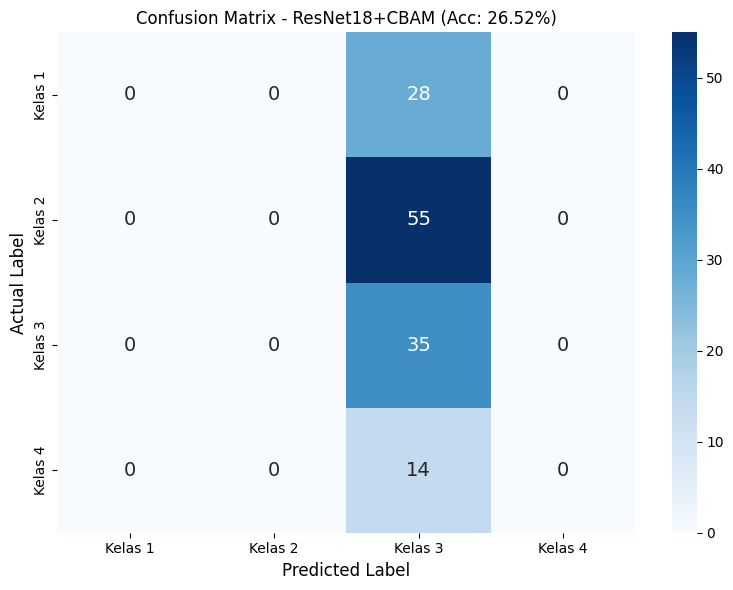

In [ ]:
# =================================================================================================
# 6. EVALUASI DAN METRIK (OTOMATIS)
# =================================================================================================
print("\n[INFO] Melakukan Evaluasi Menyeluruh...")

# Load best model
try:
    model.load_weights(MODEL_SAVE_PATH)
    print(f"✓ Best model loaded from {MODEL_SAVE_PATH}")
except:
    print("⚠️ Using current model weights")

# Prediksi (menghasilkan probabilitas, misal [0.1, 0.8, 0.05, 0.05])
Y_pred_probs = model.predict(test_ds, verbose=1)

# Ambil kelas dengan probabilitas tertinggi
y_pred = np.argmax(Y_pred_probs, axis=1)

# Label asli (Ground Truth)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

class_names = ['Kelas 1', 'Kelas 2', 'Kelas 3', 'Kelas 4']

# --- Metrik 1: Akurasi Global ---
test_acc = accuracy_score(y_true, y_pred)

# --- Metrik 2: Confusion Matrix ---
cm = confusion_matrix(y_true, y_pred)
cm_str = str(cm.tolist())
print("\nConfusion Matrix:")
print(cm)

# --- Metrik 3: Confidence Statistics ---
confidence_scores = np.max(Y_pred_probs, axis=1)
avg_conf = np.mean(confidence_scores)
min_conf = np.min(confidence_scores)
std_conf = np.std(confidence_scores)

# --- Metrik 4: Precision, Recall, F1 Per Kelas ---
report = classification_report(y_true, y_pred, target_names=class_names, digits=4, output_dict=True)
print("=" * 60)
print("Classification Report")
print("=" * 60)
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

print(f"✅ Akurasi Test Akhir: {test_acc*100:.2f}%")
print(f"✅ Rata-rata Confidence: {avg_conf*100:.2f}%")

import matplotlib.pyplot as plt
import seaborn as sns

# Plot Confusion Matrix
plot_folder = "history_plots_RN18" 
if not os.path.exists(plot_folder):
    os.makedirs(plot_folder)

current_time_str = datetime.now().strftime("%Y%m%d_%H%M%S")
plot_filename = f"cm_resnet18_cbam_{current_time_str}_Acc{test_acc*100:.1f}.png"
plot_filepath = os.path.join(plot_folder, plot_filename)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            annot_kws={"size": 14})
plt.title(f'Confusion Matrix - ResNet18+CBAM (Acc: {test_acc*100:.2f}%)')
plt.ylabel('Actual Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()

plt.savefig(plot_filepath, dpi=300, bbox_inches='tight')
print(f"\n🖼️ Gambar Confusion Matrix tersimpan di: {plot_filepath}")

plt.show()

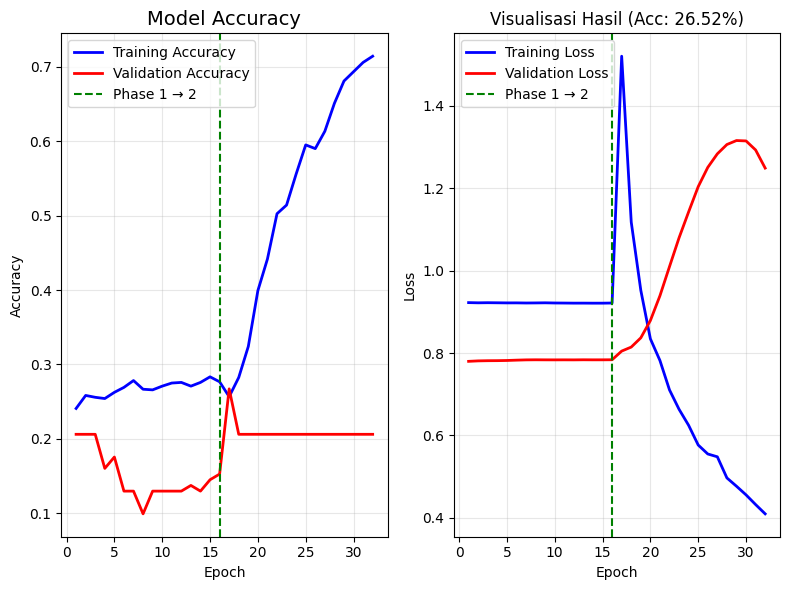

In [15]:
test_accuracy = accuracy_score(y_true, y_pred)
# Gabungkan history dari kedua phase
acc = history_1.history['accuracy'] + history_2.history['accuracy']
val_acc = history_1.history['val_accuracy'] + history_2.history['val_accuracy']
loss = history_1.history['loss'] + history_2.history['loss']
val_loss = history_1.history['val_loss'] + history_2.history['val_loss']

epochs_range = range(1, len(acc) + 1)
phase1_end = len(history_1.history['accuracy'])

fig, axes = plt.subplots(1, 2, figsize=(8, 6))

# Plot Accuracy
axes[0].plot(epochs_range, acc, 'b-', label='Training Accuracy', linewidth=2)
axes[0].plot(epochs_range, val_acc, 'r-', label='Validation Accuracy', linewidth=2)
axes[0].axvline(x=phase1_end, color='green', linestyle='--', label='Phase 1 → 2')
axes[0].set_title('Model Accuracy', fontsize=14)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot Loss
axes[1].plot(epochs_range, loss, 'b-', label='Training Loss', linewidth=2)
axes[1].plot(epochs_range, val_loss, 'r-', label='Validation Loss', linewidth=2)
axes[1].axvline(x=phase1_end, color='green', linestyle='--', label='Phase 1 → 2')
axes[1].set_title('Model Loss', fontsize=14)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Siapkan Folder Penyimpanan Gambar
plot_folder = "visualizations_RN18" 
if not os.path.exists(plot_folder):
    os.makedirs(plot_folder) # Buat folder otomatis jika belum ada
# Buat Nama File Unik (Timestamp + Akurasi)
current_time_str = datetime.now().strftime("%Y%m%d_%H%M%S")
plot_filename = f"cm_{current_time_str}_Acc{test_accuracy*100:.1f}.png"
plotfilepath = os.path.join(plot_folder, plot_filename)

plt.savefig(plotfilepath, dpi=300, bbox_inches='tight')
plt.title(f'Visualisasi Hasil (Acc: {test_accuracy*100:.2f}%)')
plt.tight_layout()
plt.show()

In [16]:
# =================================================================================================
# 7. SISTEM PENYIMPANAN LOG (AUTO-CSV)
# =================================================================================================
# Bagian ini yang akan menyimpan "Jejak Percobaan" kamu selamanya.

# Dictionary data untuk satu baris CSV
log_data = {
    # Waktu
    "Timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    
    # Model Info
    "Model": f"ResNet18 + CBAM ({USE_CBAM})",
    
    # Parameter Setup
    "Optimizer": OPTIMIZER_NAME,
    "Batch_Size": BATCH_SIZE,
    "Layer_Config": str(LAYER_CONFIG),
    "Dropout": DROPOUT_RATE,
    "Fine_Tune_At": FINE_TUNE_AT,
    "Use_CBAM": USE_CBAM,
    "SE_Reduction_Ratio": SE_REDUCTION_RATIO,
    "Spatial_Kernel": SPATIAL_KERNEL_SIZE,
    
    # Parameter Training
    "LR_Phase_1": LR_PHASE_1,
    "Epochs_P1": EPOCHS_PHASE_1,
    "LR_Phase_2": LR_PHASE_2,
    "Epochs_P2": EPOCHS_PHASE_2,
    "Label_Smoothing": LABEL_SMOOTHING,
    "Use_Class_Weights": USE_CLASS_WEIGHTS,
    
    # Hasil Evaluasi Global
    "Accuracy": round(test_acc, 4),
    "Val_Acc_P1": round(p1_best_val_acc, 4),
    "Val_Acc_P2": round(p2_best_val_acc, 4),
    "Avg_Confidence": round(avg_conf, 4),
    "Min_Confidence": round(min_conf, 4),
    "Std_Confidence": round(std_conf, 4),
    "Confusion_Matrix": cm_str
}

# Loop otomatis untuk mengambil Precision/Recall/F1 tiap kelas
for label in class_names:
    metrics = report[label]
    log_data[f"Class_{label}_Prec"] = round(metrics['precision'], 4)
    log_data[f"Class_{label}_Rec"] = round(metrics['recall'], 4)
    log_data[f"Class_{label}_F1"] = round(metrics['f1-score'], 4)

# Buat DataFrame (1 baris)
df_new_log = pd.DataFrame([log_data])

# Logika Penyimpanan: Append jika file ada, Write jika belum ada
if not os.path.exists(LOG_FILE_PATH):
    df_new_log.to_csv(LOG_FILE_PATH, index=False)
    print(f"\n[SAVE] File log baru dibuat: {LOG_FILE_PATH}")
else:
    df_new_log.to_csv(LOG_FILE_PATH, mode='a', header=False, index=False)
    print(f"\n[SAVE] Hasil percobaan berhasil ditambahkan ke: {LOG_FILE_PATH}")

print("="*60)
print("PROSES SELESAI. SILAKAN UBAH PARAMETER DI ATAS UNTUK PERCOBAAN BERIKUTNYA.")
print("="*60)


[SAVE] Hasil percobaan berhasil ditambahkan ke: experiment_log_resnet18_cbam.csv
PROSES SELESAI. SILAKAN UBAH PARAMETER DI ATAS UNTUK PERCOBAAN BERIKUTNYA.


In [17]:
# =================================================================================================
# 8. VISUALISASI CBAM ATTENTION MAP (OPSIONAL)
# =================================================================================================
# Visualisasi ini menunjukkan "di mana" model fokus saat membuat prediksi
# Sangat berguna untuk memahami apakah model melihat area fluorescence yang relevan

def visualize_cbam_attention(model, test_ds, num_samples=4):
    """
    Visualisasi spatial attention map dari CBAM
    Menunjukkan area mana yang difokuskan model
    """
    # Cari layer spatial attention terakhir (dari layer4)
    spatial_layers = [l for l in model.layers if 'sa_conv' in l.name or 'sp_sa_conv' in l.name]
    
    if not spatial_layers:
        print("⚠️ Tidak ada CBAM spatial attention layer ditemukan.")
        print("   Pastikan USE_CBAM = True saat membangun model.")
        return
    
    # Ambil layer spatial attention terakhir
    target_layer = spatial_layers[-1]
    print(f"📍 Menggunakan attention layer: {target_layer.name}")
    
    # Buat model untuk ekstrak attention map
    attention_model = tf.keras.Model(
        inputs=model.input,
        outputs=[target_layer.output, model.output]
    )
    
    # Ambil beberapa sample dari test set
    images_list = []
    labels_list = []
    for imgs, lbls in test_ds:
        images_list.append(imgs.numpy())
        labels_list.append(lbls.numpy())
        if len(images_list) * imgs.shape[0] >= num_samples:
            break
    
    images = np.concatenate(images_list, axis=0)[:num_samples]
    labels = np.concatenate(labels_list, axis=0)[:num_samples]
    
    # Dapatkan attention maps dan prediksi
    attention_maps, predictions = attention_model.predict(images, verbose=0)
    
    class_names = ['Kelas 1', 'Kelas 2', 'Kelas 3', 'Kelas 4']
    
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    for i in range(num_samples):
        true_label = np.argmax(labels[i])
        pred_label = np.argmax(predictions[i])
        confidence = np.max(predictions[i]) * 100
        
        # Original image
        axes[i, 0].imshow(images[i])
        axes[i, 0].set_title(f'Original\nTrue: {class_names[true_label]}', fontsize=11)
        axes[i, 0].axis('off')
        
        # Attention map (resize ke ukuran gambar)
        att_map = attention_maps[i, :, :, 0]
        att_resized = tf.image.resize(
            att_map[..., np.newaxis], 
            (224, 224), 
            method='bilinear'
        ).numpy()[:, :, 0]
        
        axes[i, 1].imshow(att_resized, cmap='jet')
        axes[i, 1].set_title(f'Spatial Attention Map', fontsize=11)
        axes[i, 1].axis('off')
        
        # Overlay
        axes[i, 2].imshow(images[i])
        axes[i, 2].imshow(att_resized, cmap='jet', alpha=0.4)
        correct = "✓" if true_label == pred_label else "✗"
        axes[i, 2].set_title(
            f'{correct} Pred: {class_names[pred_label]} ({confidence:.1f}%)', 
            fontsize=11,
            color='green' if true_label == pred_label else 'red'
        )
        axes[i, 2].axis('off')
    
    plt.suptitle('CBAM Spatial Attention Visualization', fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    # Save
    plot_folder = "history_plots"
    if not os.path.exists(plot_folder):
        os.makedirs(plot_folder)
    att_filename = f"cbam_attention_{datetime.now().strftime('%Y%m%d_%H%M%S')}.png"
    plt.savefig(os.path.join(plot_folder, att_filename), dpi=200, bbox_inches='tight')
    print(f"\n🖼️ Attention map tersimpan di: {plot_folder}/{att_filename}")
    plt.show()

# Jalankan visualisasi
if USE_CBAM:
    visualize_cbam_attention(model, test_ds, num_samples=4)
else:
    print("ℹ️ CBAM tidak aktif. Set USE_CBAM = True untuk visualisasi attention.")


⚠️ Tidak ada CBAM spatial attention layer ditemukan.
   Pastikan USE_CBAM = True saat membangun model.
